<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/FFN_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for dataset management
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [52]:
pip install ucimlrepo

In [188]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [189]:
nan_indices = X[X.isna().any(axis=1)].index
nan_indices

X.drop(nan_indices, inplace=True)
y.drop(nan_indices, inplace=True)

<ipython-input-189-37305fb67aea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(nan_indices, inplace=True)
<ipython-input-189-37305fb67aea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(nan_indices, inplace=True)


In [190]:
# find the columns we want to normalize (all except quality)
normalizeColumns = X.keys()

# z-score (written out for clarity)
for col in normalizeColumns:
  meanval   = np.mean(X[col])
  stdev     = np.std(X[col],ddof=1)
  X[col] = (X[col]-meanval) / stdev

# can also do more compactly
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

X.describe()

<ipython-input-190-695dbbe76f41>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = (X[col]-meanval) / stdev


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02,2.970000e+02
mean,-1.375630e-16,-5.382900e-17,-5.457662e-17,4.994135e-16,-1.809252e-16,5.980999e-18,8.373399e-17,4.904420e-16,-1.046675e-17,-5.980999e-17,1.196200e-17,-3.588600e-17,-1.674680e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.822413e+00,-1.444542e+00,-2.236854e+00,-2.122052e+00,-2.333766e+00,-4.107570e-01,-1.001728e+00,-3.426067e+00,-6.952460e-01,-9.051839e-01,-9.749377e-01,-7.207596e-01,-8.927134e-01
25%,-7.229037e-01,-1.444542e+00,-1.640127e-01,-6.583195e-01,-6.990742e-01,-4.107570e-01,-1.001728e+00,-7.235482e-01,-6.952460e-01,-9.051839e-01,-9.749377e-01,-7.207596e-01,-8.927134e-01
50%,1.611000e-01,6.899303e-01,-1.640127e-01,-9.534545e-02,-8.366097e-02,-4.107570e-01,3.384216e-03,1.482320e-01,-6.952460e-01,-2.191498e-01,6.426964e-01,-7.207596e-01,-8.927134e-01
75%,7.136023e-01,6.899303e-01,8.724078e-01,4.676287e-01,5.509839e-01,-4.107570e-01,1.008496e+00,7.148891e-01,1.433497e+00,4.668843e-01,6.426964e-01,3.442434e-01,1.170601e+00
max,2.481610e+00,6.899303e-01,8.724078e-01,3.845473e+00,6.089703e+00,2.426332e+00,1.008496e+00,2.284094e+00,1.433497e+00,4.411580e+00,2.260330e+00,2.474249e+00,1.170601e+00


Text(0, 0.5, 'Count')

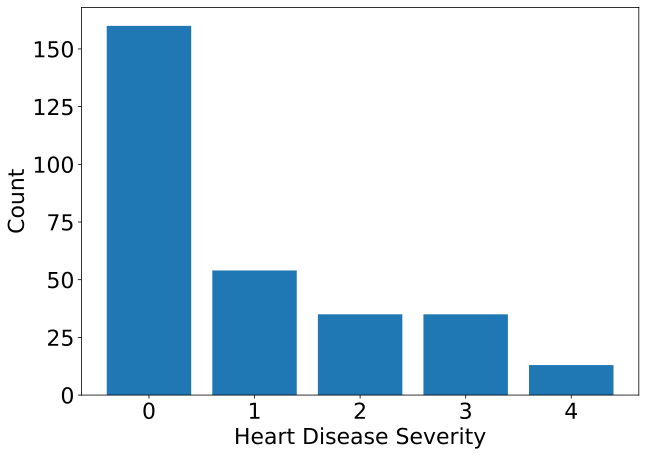

In [191]:
# distribution of heart disease severity values
fig = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = y['num'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('Heart Disease Severity')
plt.ylabel('Count')

In [192]:
y['booleanPrediction'] = 0
y['booleanPrediction'][y['num']>0] = 1

y.drop('num', axis=1, inplace=True)
y

<ipython-input-192-7fdb54ace0d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['booleanPrediction'] = 0
<ipython-input-192-7fdb54ace0d6>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step

,booleanPrediction
0,0
1,1
2,1
3,0
4,0
...,...
297,1
298,1
299,1
300,1


In [193]:
# Convert dataframes to pytorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

# Split into 20% Test 80% Train
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataloaders
train_set = TensorDataset(train_X, train_y)
test_set = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

In [265]:
# create a class for the model
def createTheHeartDiseaseNet():

  class heartDiseaseNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(13,16)

      ### hidden layer
      self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
      self.fc1 = nn.Linear(16,8)

      ### output layer
      self.output = nn.Linear(8,1)

      ### define dropout
      self.dropout = nn.Dropout(p=0.2)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = self.bnorm1(x)
      x = self.dropout(x)
      x = F.relu( self.fc1(x) )
      x = self.output(x)
      return x

  # create the model instance
  net = heartDiseaseNet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.02)

  return net,lossfun,optimizer

In [266]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 150

  # create a new model
  net,lossfun,optimizer = createTheHeartDiseaseNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):
    net.train()
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for features,labels in train_loader:

      # forward pass and loss
      pred = net(features)
      loss = lossfun(pred, labels)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      batchAcc.append( 100*torch.mean(((pred>0) == labels).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    features, labels = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      pred = net(features)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean(((pred>0) == labels).float()).item() )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [246]:
# test the network
testX, testY = next(iter(train_loader))

net, lossfun, optimizer = createTheHeartDiseaseNet()

pred = net(testX)

In [267]:
trainAcc, testAcc, losses, net = function2trainTheModel()

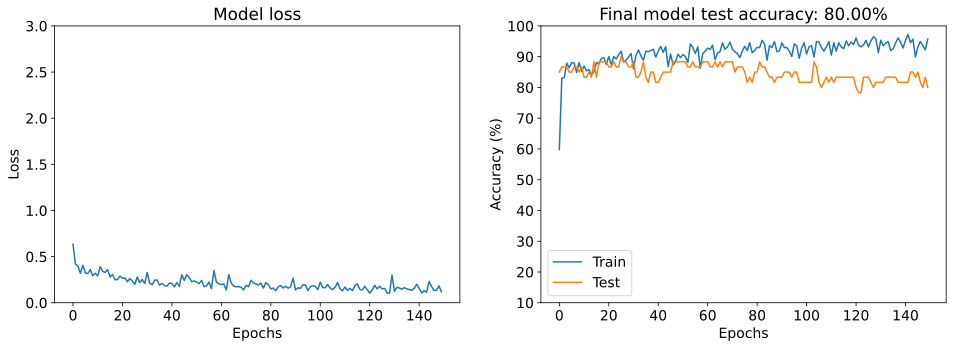

In [268]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

plt.rcParams.update({'font.size': 14})

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()